# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name:Hemiao 

Last Name:Cui

Student ID:999470055

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla 
import sqlite3 as sql
%matplotlib inline
plt.style.use('ggplot')
import shapely.geometry as geom
plt.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns
import geopandas as gpd
import numpy as np

In [17]:
sf_conn = sql.connect("C:/Users/Hemiao Cui/Desktop/Jupyter/sta141b-hw5/sf_data.sqlite")
df1=pd.read_sql_query("""
select a.permit, a.Applicant,b.locationid,b.permit
from mobile_food_permits as a
INNER JOIN mobile_food_schedule as b
on a.permit=b.permit""",sf_conn) 
df1.head()

,permit,Applicant,locationid,permit
0,16MFF-0027,F & C Catering,762178,16MFF-0027
1,16MFF-0027,F & C Catering,762178,16MFF-0027
2,16MFF-0027,F & C Catering,762178,16MFF-0027
3,16MFF-0027,F & C Catering,762178,16MFF-0027
4,16MFF-0027,F & C Catering,762178,16MFF-0027


In [18]:
grouped=df1.groupby("Applicant").locationid.nunique().reset_index(name='counts')
grouped.sort_values(by="counts",ascending=False).head()

,Applicant,counts
68,May Catering,58
3,Anas Goodies Catering,37
77,Natan's Catering,37
59,Liang Bai Ping,33
80,Park's Catering,23


Above result showed that May Catering,Anas Goodies Catering, and Natan's Catering have the highest numbers of locations where they sell. 

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

1.2.1 Question: Which parts of the city are the most and least expensive?

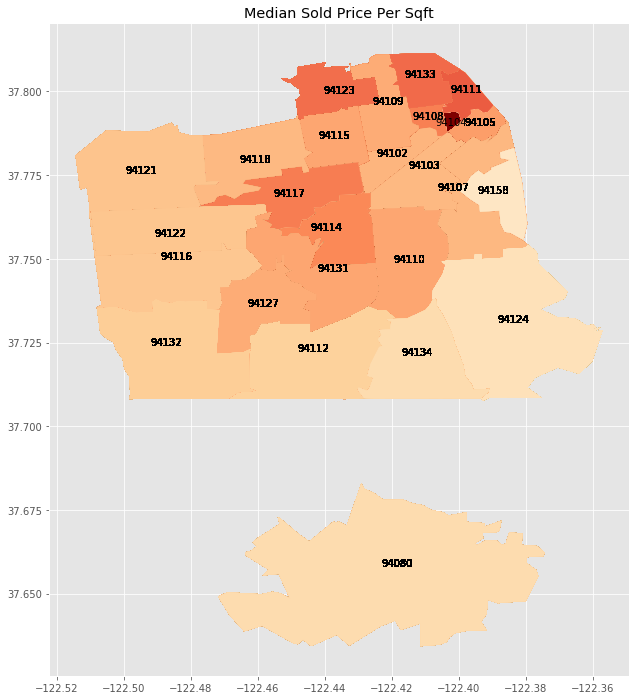

In [19]:
zildf=pd.read_sql_query("select * from zillow",sf_conn)
zips=gpd.read_file('cb_2015_us_zcta510_500k.shp')
#Select zip code that match zilllow: 
zips=zips[zips.ZCTA5CE10.str.startswith("9")]
wanted = [str(x) for x in zildf["RegionName"].values]
zilzip=zips[zips.ZCTA5CE10.isin (wanted)]
#slice and rename columns and then join dataframes:
price=zildf.loc[:,['MedianSoldPricePerSqft_AllHomes','RegionName']].dropna()
price.RegionName=price.RegionName.astype(str)
price.columns=['MedianSoldPricePerSqft_AllHomes','ZCTA5CE10']
price=price.set_index('ZCTA5CE10')
zilgeom=zilzip.loc[:,['ZCTA5CE10','geometry']]
zilgeom=zilgeom.reset_index(drop=True).set_index('ZCTA5CE10',drop=True)
zilprice_geom=zilgeom.join(price)
zilprice_geom=zilprice_geom.reset_index()
ax=zilprice_geom.plot(column='MedianSoldPricePerSqft_AllHomes', cmap="OrRd")
ax.set(title = "Median Sold Price Per Sqft")

def add_label(row):
    """This function takes a row and return the annotation for that row"""
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.ZCTA5CE10, xy = coords, horizontalalignment = "center")  
zilprice_geom.apply(add_label, axis = 1) 
plt.show()

From above result, we can see that zip codes 94104, 94133, 94111, and 94123 are among the places where the housing are most expensive. Those zip codes respecitivaly are Financial District, Fishermans Wharf, Embarcadero North and Cow Hollow. This area is also where Chinatown located. Zip codes 94158, 94124, 94134 are among the places where housing are the least expensive.  They correspond to 	Mission Bay,Bayview, and Portola. The people living in ZIP code 94124 are primarily black or African American. I am not very familiar with this city, but areas near Finalcial district is expensive makes sense.

Something out of my expectation about this plot is that some areas inland are more expensive than areas on the coastlines because rich people all like to live by the sea. The relatively expensive areas inland are 94117, corresponds to Buena Vista Park and 94114, correspondes to Castro. The people living in ZIP code 94114 are primarily white. It seesm that there is a lot of segregation in terms of where people live in this city. 


1.2.2 a)Which parts of the city are the most dangerous and b) at what time?

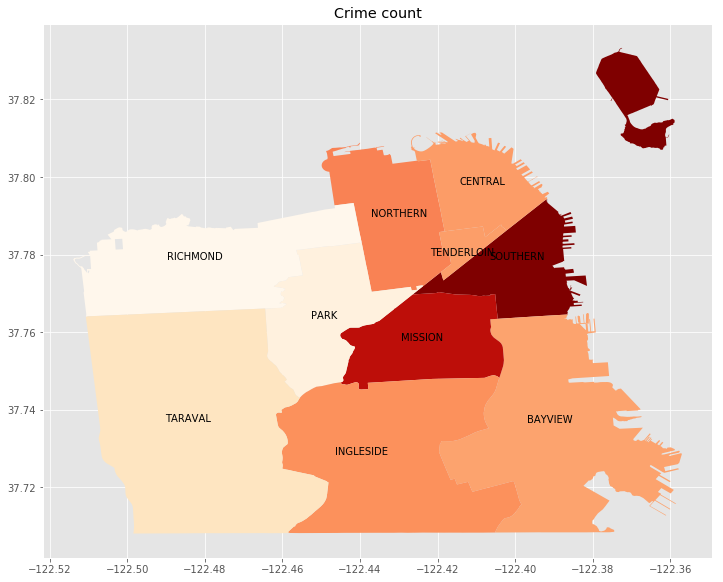

In [20]:
#I look at robbery crime:
crimdf=pd.read_sql_query("""select Count(IncidntNum) as count,Category,PdDistrict  
from crime where Category='ROBBERY'group by PdDistrict""",sf_conn) 
distr=gpd.read_file('geo_export_9a15d861-d90b-4050-bcf7-c89270ce87ee.shp')
#join shapefile and crime dataframe by district
joincrimgeom=distr.set_index('district').join(crimdf.set_index('PdDistrict'))
joincrimgeom=joincrimgeom.reset_index()
ax=joincrimgeom.plot(column='count', cmap="OrRd")
ax.set(title = "Crime count")
def add_label(row):
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.district, xy = coords, horizontalalignment = "center")  
joincrimgeom.apply(add_label, axis = 1) 
plt.show()

From above result, we can see that southern district and mission district are among the highest number of crimes. Also, the treasure island has high number of crimes. The places where there are least number of crimes are Richmond and Park. It is interesting that the number of crimes are somewhat associated with the price of housing. For example, southern district are close to zip code 94158. It is reasonable that places that are cheaper are reported with higher amount of crime rate. 

However, the crime count does not have a direct relationship with housing price. In rich areas, especially the Financial District, there is also a relatively high crime rate. It would be very interesting to look at whether the type of crime is different from the poor area. Richmond, Park and Taraval have the least amount of crimes. It is also interesting to note that the police district area is also larger in Taravel than others. 

In [21]:
crimtimedf=pd.read_sql_query("select IncidntNum,DayOfWeek,Datetime from crime where Category='ROBBERY'",sf_conn)
def crimtime(row):
    """This function takes in a row in the crime dataframe and returns which the time period it falls"""
    Temp=''
    if 0<=int(row[2].split()[-1][0:2])<6:
        Temp='Early morning'
    if 6<=int(row[2].split()[-1][0:2])<12:
        Temp='Morning'
    if 12<=int(row[2].split()[-1][0:2])<18:
        Temp='Afternoon'
    if 18<=int(row[2].split()[-1][0:2])<24:
        Temp='Night'
    return Temp
crimtimedf['crimtime']=crimtimedf.apply(crimtime,axis=1)
crimtimedf.head()

,IncidntNum,DayOfWeek,Datetime,crimtime
0,150098210,Sunday,2015-02-01 15:45:00,Afternoon
1,150098367,Sunday,2015-02-01 16:20:00,Afternoon
2,150098414,Sunday,2015-02-01 17:05:00,Afternoon
3,150098414,Sunday,2015-02-01 17:05:00,Afternoon
4,150098420,Sunday,2015-02-01 17:10:00,Afternoon


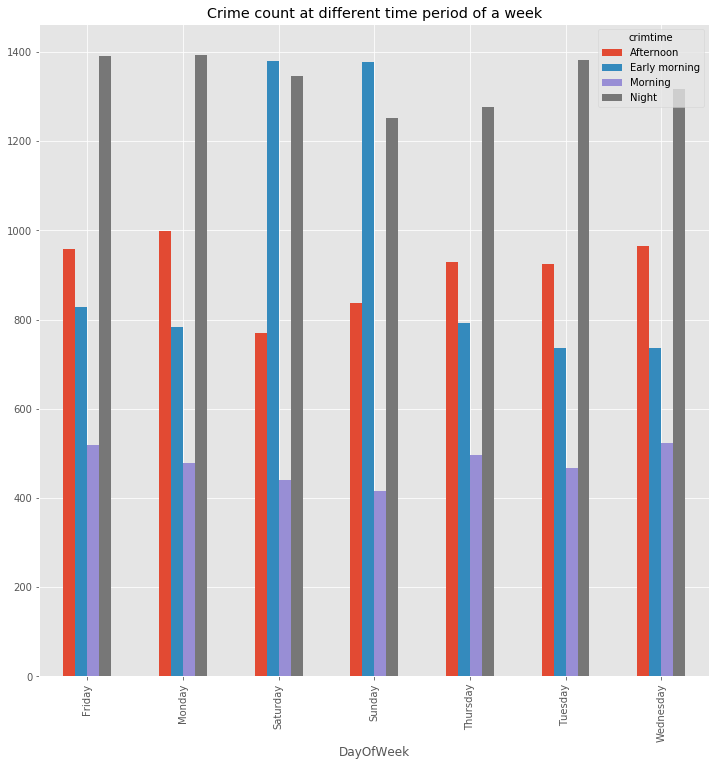

In [22]:
crimcount=crimtimedf.groupby(['DayOfWeek','crimtime'])['IncidntNum'].count().unstack()
crimcount.plot(kind = 'bar', title ='Crime count at different time period of a week')

The above result showed that at any day of week, crime happened most at night and least in the morning. But, on Saturday and Sunday, there is also a very high crime rate happening in early morning, which is defined as 0 to 6 am. 

1.2.3. What are the best times and places to find food trucks?

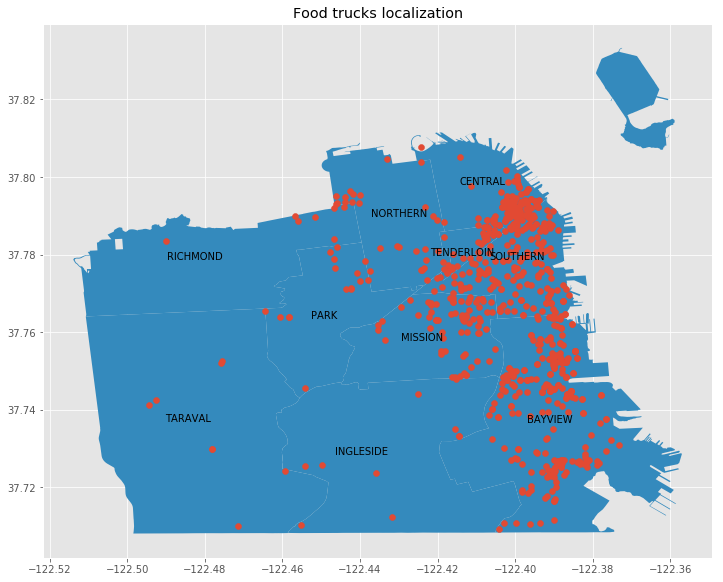

In [23]:
foodlocation=pd.read_sql_query("select * from mobile_food_locations",sf_conn) 
foodlocation=foodlocation.loc[foodlocation['Longitude']!=0,:] #one data point has a weired longitude
lnglat =[geom.Point(lng,lat) for lng, lat in zip(foodlocation.Longitude,foodlocation.Latitude)] 
foodgeo=gpd.GeoDataFrame(foodlocation, geometry = lnglat)
ax=distr.plot()
foodgeo.plot(ax=ax) 

def add_label(row):
    """This function takes in a row and returns anotation"""
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.district, xy = coords, horizontalalignment = "center")  
distr.apply(add_label, axis = 1) 
ax.set(title = "Food trucks localization")
plt.show()

From above result, we can see most food trucks are located on the right hand side of above plot. It might be due to high population in those districts. Also, when compared to the first map, we can see that there is a cluster of food trucks near zip code 94104 where Financial district is located. These areas might host a lot of companeies. People working there are very busy to cook. In Southern and Bayview, there are also a lot of food trucks available. 

[Text(0,0.5,u'Number of food trucks'),
 Text(0.5,0,u'Time/h'),
 Text(0.5,1,u'Occurances of food truck at different time')]

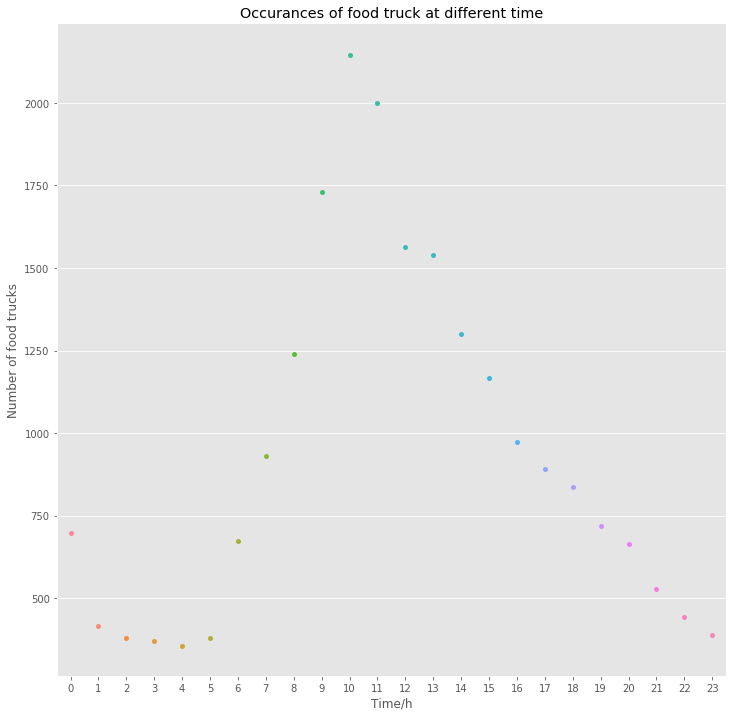

In [24]:
foodsched=pd.read_sql_query("select * from mobile_food_schedule",sf_conn) 
timecheck=np.zeros((24, 0),dtype=bool)
for row in foodsched.itertuples():
    if row[4]>row[5]: #row[4] is the end time of food truck; row[5] is the start time of food truck
        checkresult=np.in1d(range(0,24),range(row[5],row[4]+1))  #this is to creat an array catching whether the time falls in 0am to 23pm.
        timecheck=np.hstack([timecheck, checkresult[:, None]])
    if row[4]<row[5]:
        checkresult=np.in1d(range(0,24),(range(row[5],24)+range(0,row[4]+1))) 
        timecheck=np.hstack([timecheck, checkresult[:, None]])
timecheck #this is a (24L, 3587L) array
ax = sns.stripplot(x=range(0,24),y=np.sum(timecheck,axis=1)) 
ax.set(title = "Occurances of food truck at different time", xlabel = "Time/h", ylabel = "Number of food trucks")

From above result, we can see that there is a clear up and down trends of available food trucks. Before doing the plot, I thought that the peak time of food truck should be in the afternoon. But, the result is showing that very interesting, the time where there are most food trucks are around 10 am. The number of food trucks decreased a little bit from that in the afternoon. There are actually less trucks available in the noon time. It could be possible that a large amount of food trucks sell breakfast rather than lunch. Compared to food truck here on campus, the food trucks are almost not avaiable before or even at 10am. Also, it is interestingly to note there are still food trucks at midnight and even in the early morning from 0 to 6 am. From here, it is indicating that the people in the city are living in a busy life. 

1.2.4 Is there a relationship between housing prices and schools? 

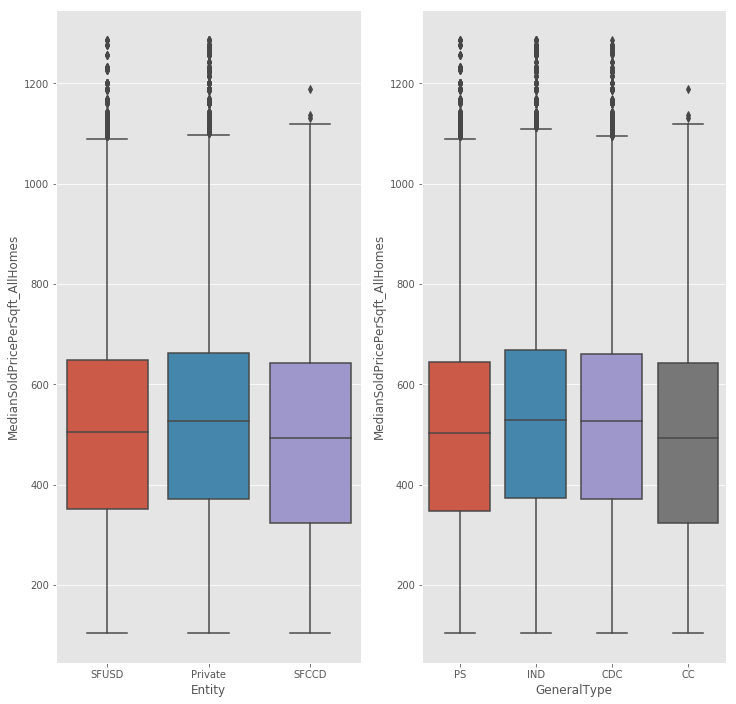

In [25]:
scho=pd.read_sql_query("select Name, Entity,GradeRange,Category,GeneralType,Lat,Lon from schools",sf_conn) 
scho=scho.dropna(subset=["Lat", "Lon"])
lnglat =[geom.Point(lng,lat) for lng, lat in zip(scho.Lon,scho.Lat)] 
schogeo=gpd.GeoDataFrame(scho, geometry = lnglat)  
joined= gpd.sjoin(schogeo,zilprice_geom, how = "inner", op = "within")
f, axes = plt.subplots(1, 2)
sns.boxplot(x="Entity", y="MedianSoldPricePerSqft_AllHomes",data=joined,ax=axes[0])
sns.boxplot(x="GeneralType", y="MedianSoldPricePerSqft_AllHomes",data=joined,ax=axes[1])

Text(0.5,1,u'Percertage of school numbers in different areas')

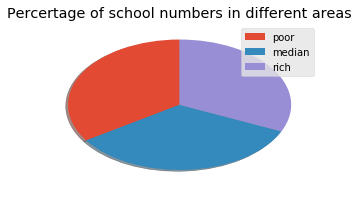

In [26]:
fig = plt.figure(figsize=(5,3))
schoolcount=joined.groupby('MedianSoldPricePerSqft_AllHomes').Name.count().reset_index(name='counts')
temp=int(round(schoolcount.shape[0]/3)) #this is to split the school count into three categoies
poorarea=float(schoolcount.loc[range(temp),:]['counts'].sum()) #number of schools in poor area
medianarea=float(schoolcount.loc[range(temp,2*temp),:]['counts'].sum())
richarea=float(schoolcount.loc[range(2*temp,schoolcount.shape[0]),:]['counts'].sum())
allarea=poorarea+medianarea+richarea #total number of schools
sizes=[poorarea/allarea,medianarea/allarea,richarea/allarea]
labels=['poor','median','rich']
patches, texts =plt.pie(sizes, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title('Percertage of school numbers in different areas')

To see whether housing is related to the distibution of schools, I joined both the housing and school dataframe according to  lon and lat. Then, I group the schools into SFUSD, Private and SFCCD to see if there is any differences of prices of house where those kinds of schools are located. From the boxplot, there is a big variation of housing prices for all three schools types. In the locations of private schools, there is a slightly higher mean price than the other two school types. Both SFUSD, Private have a lot more outliers at the high end, meaning that people who live in very expensive areas tends to go to  SFUSD, Private schools rather than SFCCD. 

I also grouped the school based on PS, IND, CDC and CC.CC group has less outlier at the high end. It seems that people living in expensive areas tends to go to PS, IND, CDC more than CC schools. 

I also counted number of schools in regions that most expensive, median and least expensive, which I called rich, median and poor in the pie chart. The number of schools seems to tie in those three types of regions, which is out of my expectation to some extent.  

1.2.5 What are the common crime types in each district? 

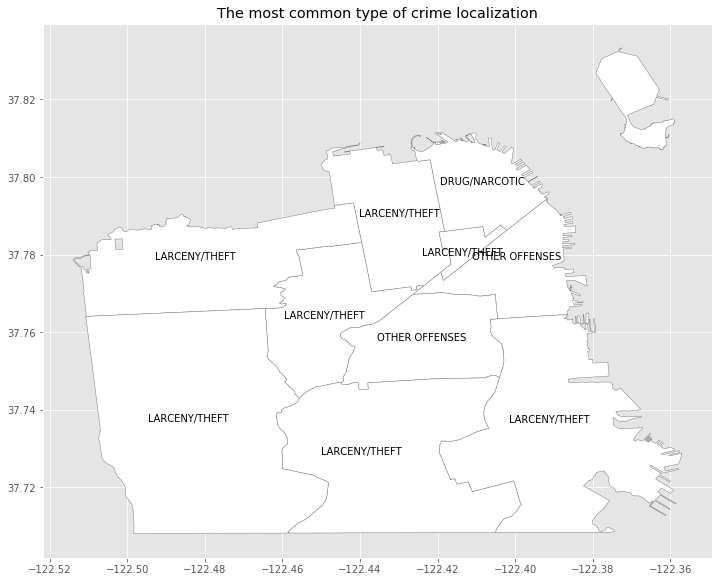

,PdDistrict,counts
0,BAYVIEW,18791
1,CENTRAL,36299
2,INGLESIDE,15125
3,MISSION,23706
4,NORTHERN,39247
5,PARK,13448
6,RICHMOND,15189
7,SOUTHERN,60068
8,TARAVAL,15777
9,TENDERLOIN,12257


In [29]:
crimdf2=pd.read_sql_query("""select IncidntNum, Category, PdDistrict,Resolution,Lon,Lat from crime""",sf_conn) 
crimebydistrict=crimdf2.groupby('PdDistrict').Category.value_counts().reset_index(name='counts')
Maxcount=crimebydistrict.groupby(['PdDistrict'], sort=False)['counts'].max().reset_index(name='counts')
Topcrime=pd.merge(Maxcount,crimebydistrict,on=['PdDistrict','counts'],how='inner')
Topcrime.set_index('PdDistrict')
distr.set_index('district')
joined=distr.join(Topcrime)
ax = joined.plot(color = "white", edgecolor = "gray")

def add_label(row):
    """This function is to annotate plot"""
    coords = row.geometry.representative_point().coords[0]
    ax.annotate(row.Category, xy = coords, horizontalalignment = "center") #xy is the position to put the label. 
joined.apply(add_label, axis = 1) 
ax.set(title = "The most common type of crime localization")
plt.show()
Maxcount

I looked at the most common category of crime at different places. The methodology here is to first groupby district and count the number of occurances for different crime types. Then, I got the highest count for all districts. I used inner join to get the category for the highest count. The resuls showed that in most areas, the most common types of crimes are larcent/theft. They are two districts, respectively Soutern and Mission district, the most common types are called other offenses. Interestingly, in the Central District, the most common type of crime is drug crime. It seems that drug activity is very common in this places. 

I also found someone reporting heatmap of crime in this city on this website http://katiehempenius.com/post/drug-markets-of-san-francisco/?utm_content=buffer68484&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer. The result ins consistent with what I got:)

To be more fair to say that drug activity is high in TENDERLOIN, I also looked at Maxcount dataframe, which is number of occurances for the most frequent types of crime. The number of drug crime at TENDERLOIN is almost the same number of theft crime in some other places, like TARAVAL. Thus, we have more confident to say the drug activity is high in TENDERLOIN, with the most common occurance as well as high number of occurances. 
